In [30]:
import matplotlib.pyplot as plt
import bagpy
import pandas as pd
import numpy as np

In [31]:
bag = bagpy.bagreader('/shiko/AutonomX/catkin_ws/rosbags/closed_loop/infinity.bag')
bag.topic_table

[INFO]  Data folder /shiko/AutonomX/catkin_ws/rosbags/closed_loop/infinity already exists. Not creating.


,Topics,Types,Message Count,Frequency
0,/Imu,sensor_msgs/Imu,2180,91.925921
1,/SteeringAngle,std_msgs/Float64,1806,91.043956
2,/brakes,std_msgs/Float64,1797,90.949194
3,/cmd_vel,std_msgs/Float64,1797,91.127034
4,/ground_truth,nav_msgs/Odometry,1805,90.854630
5,/noisy_readings,nav_msgs/Odometry,1805,90.974839
6,/odom,nav_msgs/Odometry,2180,91.986403
7,/path_planner/trajectory,std_msgs/Float32MultiArray,1,NaN
8,/state_estimator/odometry,nav_msgs/Odometry,1805,90.777941


In [32]:
# extract topics of interest
ground_truth_topic_data = pd.read_csv(bag.message_by_topic('/ground_truth'))
noisy_data_topic_data = pd.read_csv(bag.message_by_topic('/noisy_readings'))
odometry_estimations_topic_data = pd.read_csv(bag.message_by_topic('/state_estimator/odometry'))
throttle_topic_data = pd.read_csv(bag.message_by_topic('/cmd_vel'))

# filtered_heading_topic_data = pd.read_csv(bag.message_by_topic('/filtered_heading'))

8 1670
(1, 1662)


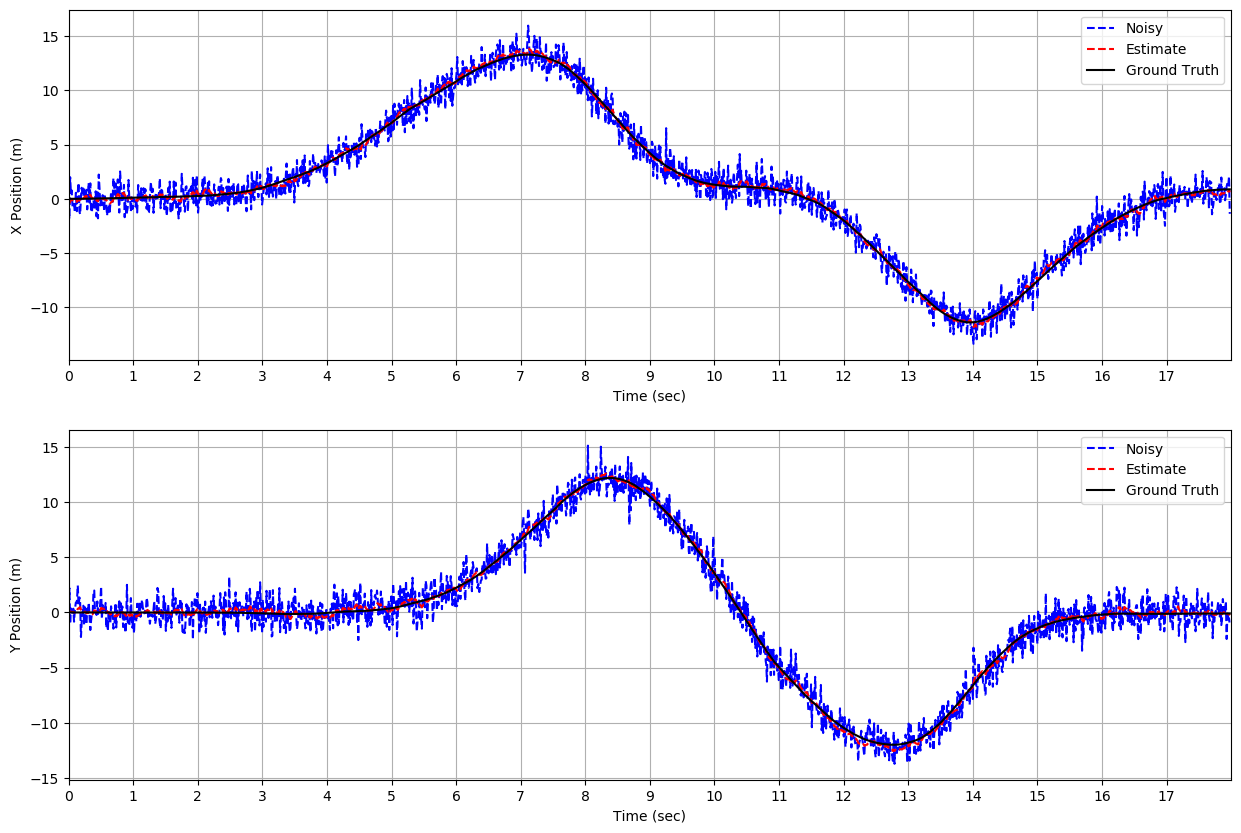

In [33]:
'''
    Plotting Ground Truth Velocity Compared to Estimated Velocities
'''

# extract the data i need and store them in a NumPy array
ground_truth_position = np.array([ground_truth_topic_data['pose.pose.position.x'], 
                         ground_truth_topic_data['pose.pose.position.y'], 
                         ground_truth_topic_data['pose.pose.position.z']])

noisy_position = np.array([noisy_data_topic_data['pose.pose.position.x'], 
                  noisy_data_topic_data['pose.pose.position.y'], 
                  noisy_data_topic_data['pose.pose.position.z']])

estimated_position = np.array([odometry_estimations_topic_data['pose.pose.position.x'], 
                      odometry_estimations_topic_data['pose.pose.position.y'], 
                      odometry_estimations_topic_data['pose.pose.position.z']])

# truncate messages before the car started moving and after it stopped
distance = np.empty_like(ground_truth_position[0])
distance[0] = 0.0
distance[1:] = np.hypot(np.diff(ground_truth_position[0, :]), np.diff(ground_truth_position[1, :]))

start_index = distance.shape[0] - len(throttle_topic_data['data'])
end_index = distance.shape[0] - np.argmax(np.where(np.flip(distance) >= 0.001, 1, 0))
print(start_index, end_index)

ground_truth_position = ground_truth_position[:, start_index:end_index]
noisy_position = noisy_position[:, start_index:end_index]
estimated_position = estimated_position[:, start_index:end_index]

# extract time stamps for each topic
ground_truth_time_stamps = np.array([ground_truth_topic_data['header.stamp.secs'] + (ground_truth_topic_data['header.stamp.nsecs'] / 1e9)])
noisy_time_stamps = np.array([noisy_data_topic_data['header.stamp.secs'] + (noisy_data_topic_data['header.stamp.nsecs'] / 1e9)])
estimated_time_stamps = np.array([odometry_estimations_topic_data['header.stamp.secs'] + (odometry_estimations_topic_data['header.stamp.nsecs'] / 1e9)])

ground_truth_time_stamps = ground_truth_time_stamps[:, start_index:end_index]
noisy_time_stamps = noisy_time_stamps[:, start_index:end_index]
estimated_time_stamps = estimated_time_stamps[:, start_index:end_index]
print(ground_truth_time_stamps.shape)

start_time = np.min([ground_truth_time_stamps[0, 0], noisy_time_stamps[0, 0], estimated_time_stamps[0, 0]])
ground_truth_time = ground_truth_time_stamps - start_time
noisy_time = noisy_time_stamps - start_time
estimated_time = estimated_time_stamps - start_time

fig1, axes1 = plt.subplots(2, 1, figsize=(15, 10))  # Create 2 rows, 1 column subplot
axes1[0].plot(noisy_time[0, :], noisy_position[1, :], label='Noisy', color='blue', linestyle = '--')
axes1[0].plot(estimated_time[0, :], estimated_position[1, :], label='Estimate', color='red', linestyle = '--')
axes1[0].plot(ground_truth_time[0, :], ground_truth_position[1, :], label='Ground Truth', color='black')
axes1[0].set_ylabel('X Position (m)')
axes1[0].set_xlabel('Time (sec)')
axes1[0].set_xlim([0.0, np.ceil(ground_truth_time[0, -1])])
axes1[0].set_xticks(np.arange(0.0, np.ceil(ground_truth_time[0, -1]), 1)) 
axes1[0].legend()
axes1[0].grid()

axes1[1].plot(noisy_time[0, :], -noisy_position[0, :], label='Noisy', color='blue', linestyle = '--')
axes1[1].plot(estimated_time[0, :], -estimated_position[0, :], label='Estimate', color='red', linestyle = '--')
axes1[1].plot(ground_truth_time[0, :], -ground_truth_position[0, :], label='Ground Truth', color='black')
axes1[1].set_ylabel('Y Position (m)')
axes1[1].set_xlabel('Time (sec)')
axes1[1].set_xlim([0.0, np.ceil(ground_truth_time[0, -1])])
axes1[1].set_xticks(np.arange(0.0, np.ceil(ground_truth_time[0, -1]), 1)) 
axes1[1].legend()
axes1[1].grid()

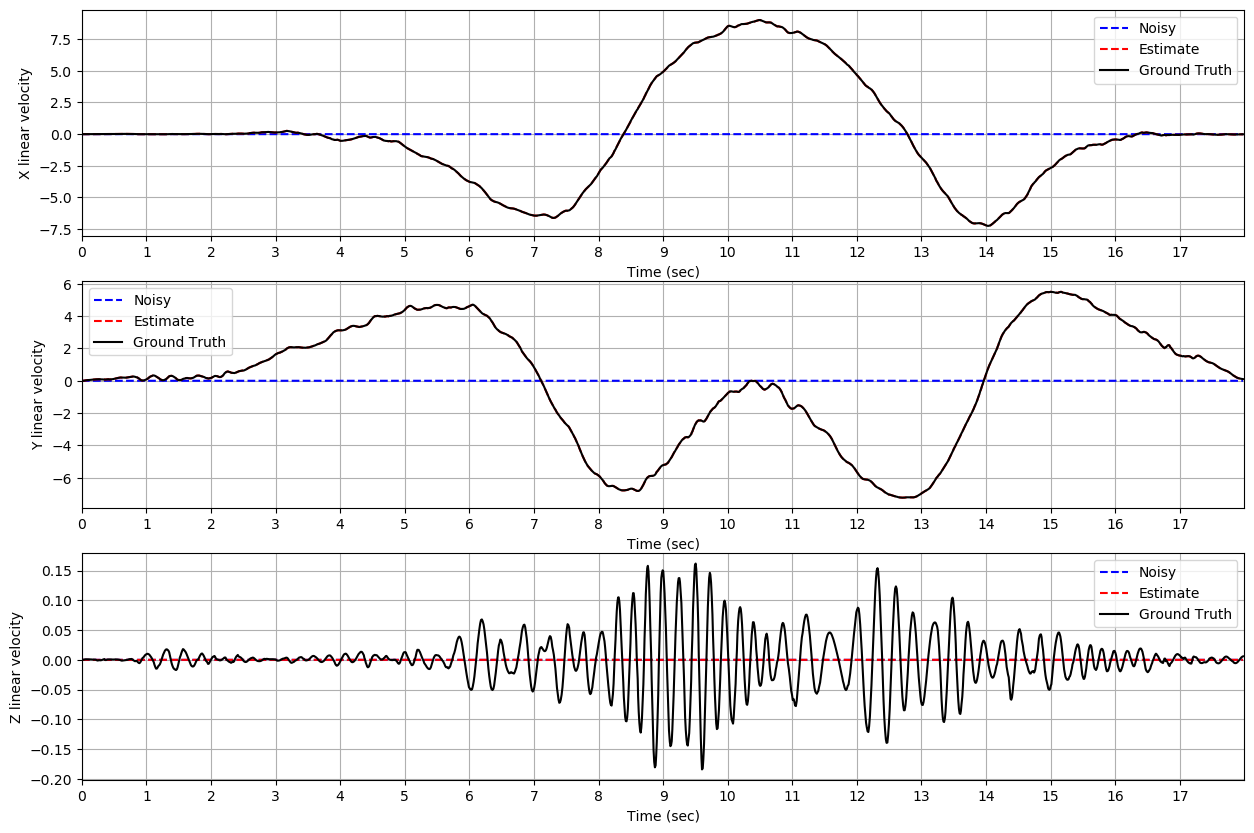

In [34]:
'''
    Plotting Ground Truth Velocity Compared to Estimated Velocities
'''

# extract the data i need as pd.sereis and store them in a list
ground_truth_velocity = np.array([ground_truth_topic_data['twist.twist.linear.x'], 
                         ground_truth_topic_data['twist.twist.linear.y'], 
                         ground_truth_topic_data['twist.twist.linear.z']])
noisy_velocity = np.array([noisy_data_topic_data['twist.twist.linear.x'], 
                  noisy_data_topic_data['twist.twist.linear.y'], 
                  noisy_data_topic_data['twist.twist.linear.z']])
estimated_velocity = np.array([odometry_estimations_topic_data['twist.twist.linear.x'], 
                      odometry_estimations_topic_data['twist.twist.linear.y'], 
                      odometry_estimations_topic_data['twist.twist.linear.z']])

# truncate messages
ground_truth_velocity = ground_truth_velocity[:, start_index:end_index]
noisy_velocity = noisy_velocity[:, start_index:end_index]
estimated_velocity = estimated_velocity[:, start_index:end_index]

fig1, axes1 = plt.subplots(3, 1, figsize=(15, 10))  # Create 3 rows, 1 column subplot
for i, ax in enumerate(axes1):
    ax.plot(noisy_time[0, :], noisy_velocity[i], label='Noisy', color='blue', linestyle = '--')
    ax.plot(estimated_time[0, :], estimated_velocity[i], label='Estimate', color='red', linestyle = '--')
    ax.plot(ground_truth_time[0, :], ground_truth_velocity[i], label='Ground Truth', color='black')
    axis = 'X' if i==0 else ('Y' if i==1 else 'Z')
    ax.set_ylabel(f'{axis} linear velocity')
    ax.set_xlabel('Time (sec)')
    ax.set_xlim([0.0, np.ceil(ground_truth_time[0, -1])])
    ax.set_xticks(np.arange(0.0, np.ceil(ground_truth_time[0, -1]), 1)) 
    ax.legend()
    ax.grid()

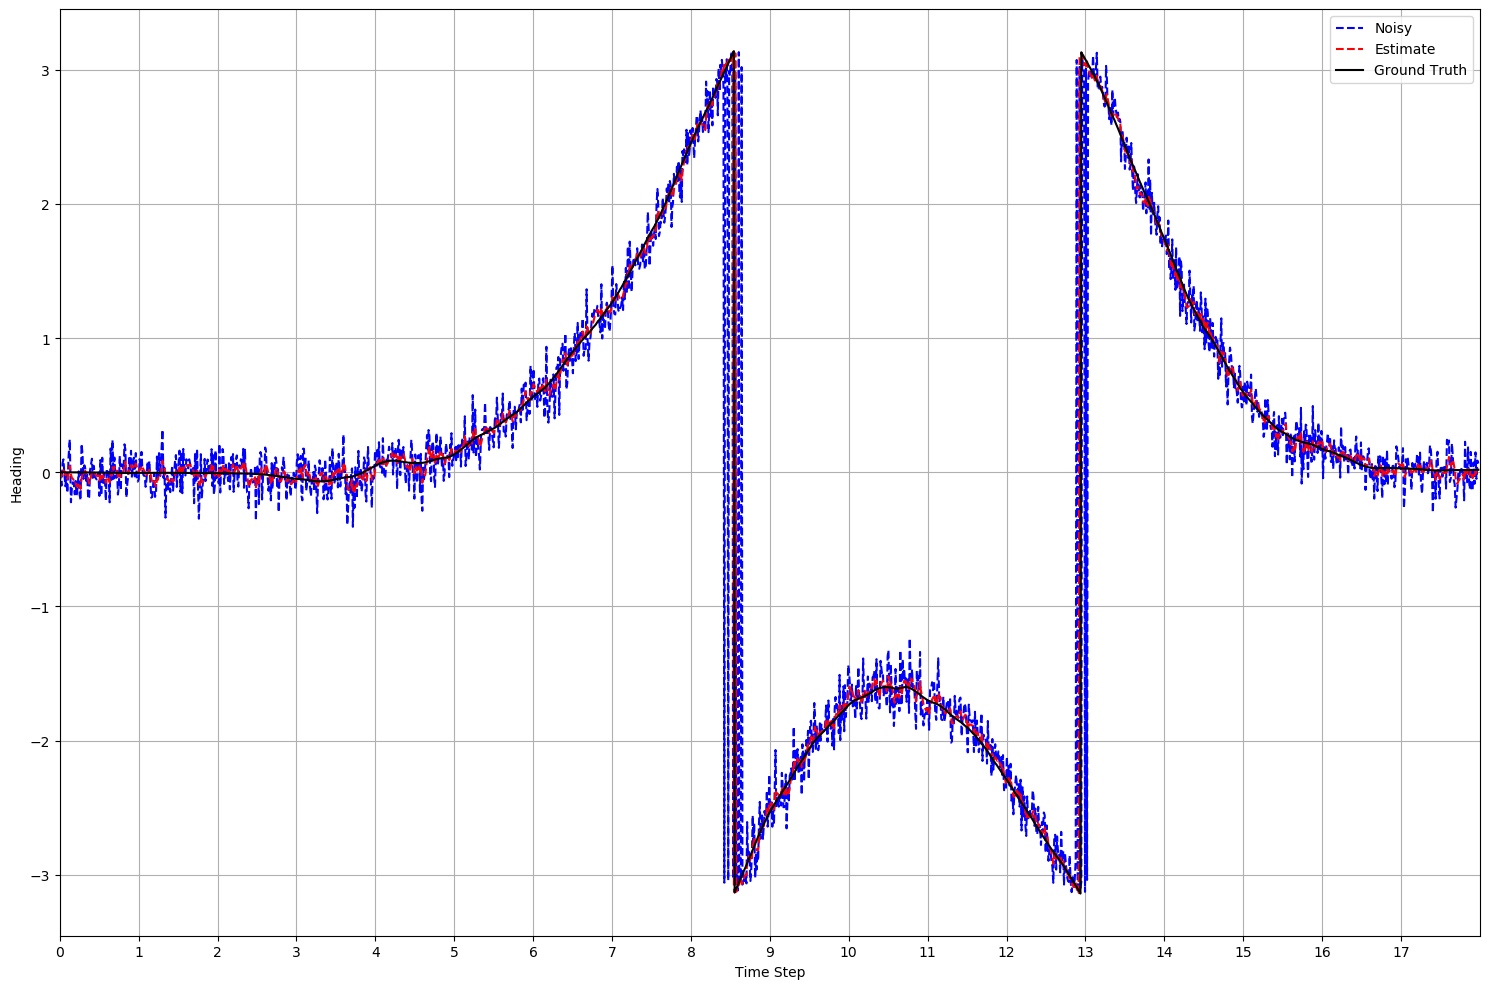

1662
1662


In [35]:
'''
    Plotting the ground truth heading compared to the estimated heading
'''
from tf.transformations import euler_from_quaternion

ground_truth_orientation = np.array([ground_truth_topic_data['pose.pose.orientation.x'], 
                            ground_truth_topic_data['pose.pose.orientation.y'], 
                            ground_truth_topic_data['pose.pose.orientation.z'], 
                            ground_truth_topic_data['pose.pose.orientation.w']])
noisy_orientation = np.array([noisy_data_topic_data['pose.pose.orientation.x'], 
                     noisy_data_topic_data['pose.pose.orientation.y'], 
                     noisy_data_topic_data['pose.pose.orientation.z'], 
                     noisy_data_topic_data['pose.pose.orientation.w']])
estimated_orientation = np.array([odometry_estimations_topic_data['pose.pose.orientation.x'], 
                         odometry_estimations_topic_data['pose.pose.orientation.y'], 
                         odometry_estimations_topic_data['pose.pose.orientation.z'], 
                         odometry_estimations_topic_data['pose.pose.orientation.w']])

# truncate messages
ground_truth_orientation = ground_truth_orientation[:, start_index:end_index]
noisy_orientation = noisy_orientation[:, start_index:end_index]
estimated_orientation = estimated_orientation[:, start_index:end_index]

# filtered_heading = filtered_heading_topic_data['data']

ground_truth_heading = np.zeros_like(ground_truth_orientation[1])
noisy_heading = np.zeros_like(noisy_orientation[1])
estimated_heading = np.zeros_like(estimated_orientation[1])

# Converting the orientation from quaternion to euler and extracting the yaw

for i in range(len(ground_truth_heading)):
    ground_truth_heading[i] = euler_from_quaternion((ground_truth_orientation[0, i], ground_truth_orientation[1, i], ground_truth_orientation[2, i], ground_truth_orientation[3, i]))[2]

for i in range(len(noisy_heading)):
    noisy_heading[i] = euler_from_quaternion((noisy_orientation[0, i], noisy_orientation[1, i], noisy_orientation[2, i], noisy_orientation[3, i]))[2]

for i in range(len(estimated_heading)):
    estimated_heading[i] = euler_from_quaternion((estimated_orientation[0, i], estimated_orientation[1, i], estimated_orientation[2, i], estimated_orientation[3, i]))[2]

fig3, axes3 = plt.subplots(1, 1, figsize=(15, 10))
axes3.plot(noisy_time[0, :], noisy_heading, label='Noisy', color='blue', linestyle='--')
axes3.plot(estimated_time[0, :], estimated_heading, label='Estimate', color='red', linestyle='--')
# axes3.plot(range(len(filtered_heading)), filtered_heading, label='Filtered', color='orange', linestyle='--')
axes3.plot(ground_truth_time[0, :], ground_truth_heading, label='Ground Truth', color='black')
axes3.set_ylabel('Heading')
axes3.set_xlabel('Time (sec)')
axes3.set_xlim([0.0, np.ceil(ground_truth_time[0, -1])])
axes3.set_xticks(np.arange(0.0, np.ceil(ground_truth_time[0, -1]), 1)) 
axes3.legend()
axes3.grid()
plt.xlabel("Time Step")
plt.tight_layout()  # Adjust spacing between subplots (optional)
plt.show()

print(len(noisy_heading))
print(len(ground_truth_heading))

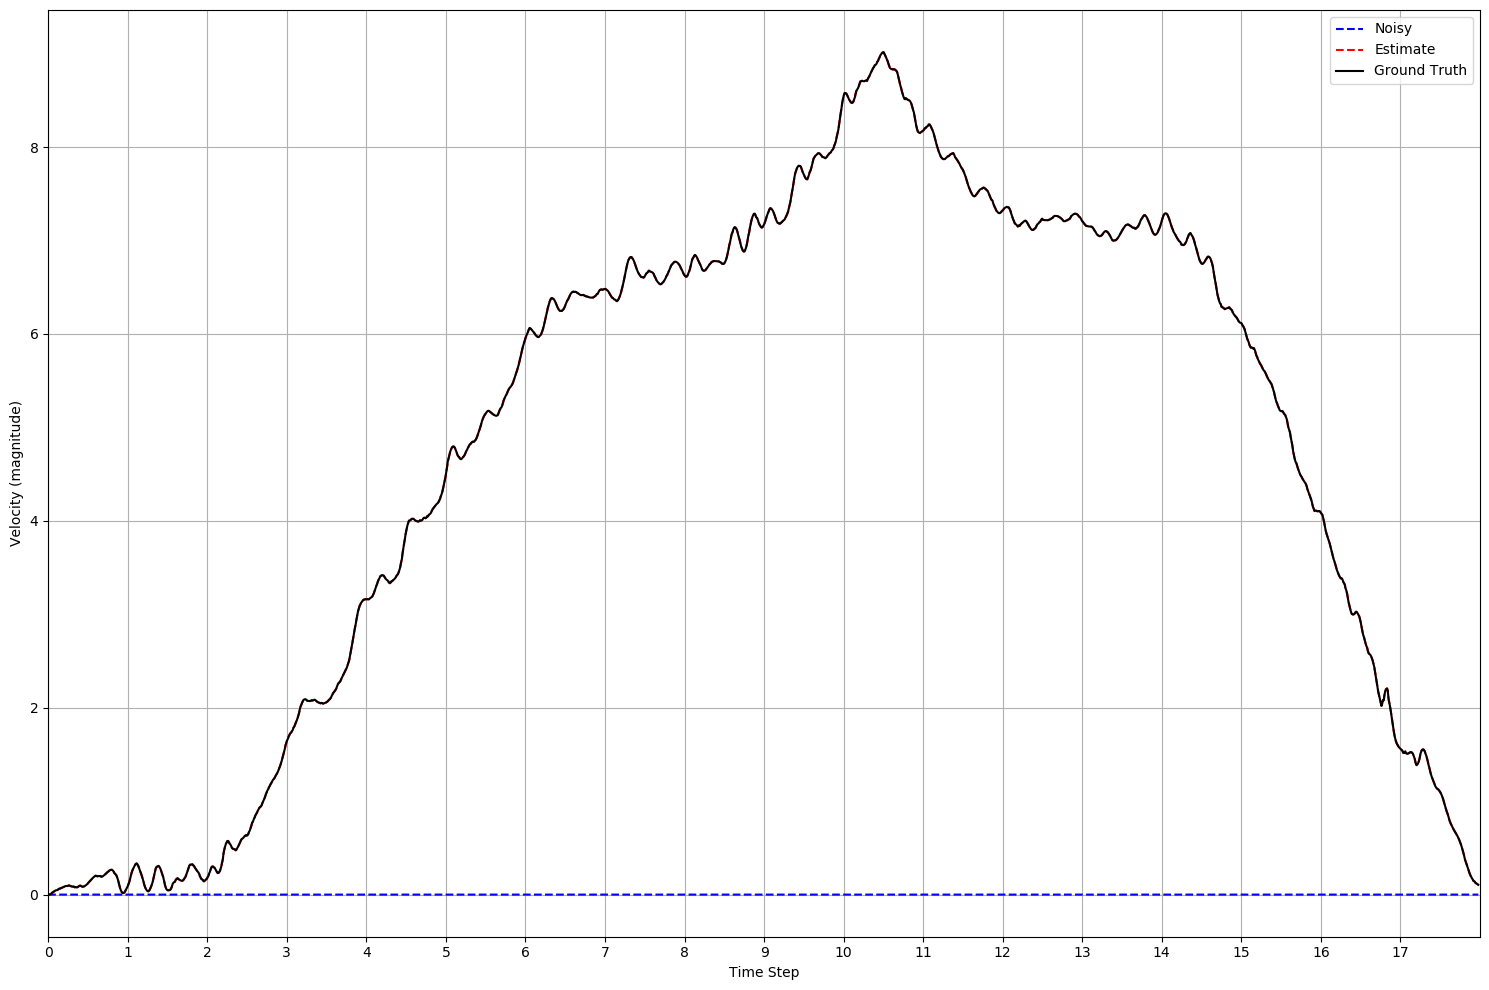

In [36]:
'''Checking Velocity Magnitudes'''
velocity_estimated = np.hypot(estimated_velocity[0], estimated_velocity[1])
velocity_actual = np.hypot(ground_truth_velocity[0], ground_truth_velocity[1])
velocity_noisy = np.hypot(noisy_velocity[0], noisy_velocity[1])

fig3, axes4 = plt.subplots(1, 1, figsize=(15, 10))
axes4.plot(noisy_time[0, :], velocity_noisy, label='Noisy', color='blue', linestyle='--')
axes4.plot(estimated_time[0, :], velocity_estimated, label='Estimate', color='red', linestyle='--')
axes4.plot(ground_truth_time[0, :], velocity_actual, label='Ground Truth', color='black')
axes4.set_ylabel('Velocity (magnitude)')
axes4.set_xlabel('Time (sec)')
axes4.set_xlim([0.0, np.ceil(ground_truth_time[0, -1])])
axes4.set_xticks(np.arange(0.0, np.ceil(ground_truth_time[0, -1]), 1)) 
axes4.legend()
axes4.grid()
plt.xlabel("Time Step")
plt.tight_layout()  # Adjust spacing between subplots (optional)
plt.show()


In [37]:
'''Making sure that all arrays are of the same length'''
if len(ground_truth_position[0])<len(estimated_position[0]):
    min1 = len(ground_truth_position[0])
else:
    min1 = len(estimated_position[0])

if len(ground_truth_velocity[0])<len(estimated_velocity[0]):
    min2 = len(ground_truth_velocity[0])
else:
    min2 = len(estimated_velocity[0])

if len(ground_truth_heading)<len(estimated_heading):
    min3 = len(ground_truth_heading)
else:
    min3 = len(estimated_heading)

''' Function for normalizing angles in rad to range from [-π, π] '''
def normalize_angle(angle):
    angle = np.fmod(angle, 2*np.pi)  # Normalize angle to be within [0, 2π]
    
    angle = np.where(angle > np.pi, angle - 2 * np.pi, angle)  # Shift to [-π, π] if necessary
    angle = np.where(angle < -np.pi, angle + 2 * np.pi, angle)
        
    return angle

'''Performing some error analytics'''

max_X_position_error = np.max(np.abs(ground_truth_position[0][:min1] - estimated_position[0][:min1]))
max_Y_position_error = np.max(np.abs(ground_truth_position[1][:min1] - estimated_position[1][:min1]))
max_Z_position_error = np.max(np.abs(ground_truth_position[2][:min1] - estimated_position[2][:min1]))

MSE_X_position = np.mean((ground_truth_position[0][:min1] - estimated_position[0][:min1])**2)
MSE_Y_position = np.mean((ground_truth_position[1][:min1] - estimated_position[1][:min1])**2)
MSE_Z_position = np.mean((ground_truth_position[2][:min1] - estimated_position[2][:min1])**2)

RMSE_X_position = np.sqrt(MSE_X_position)
RMSE_Y_position = np.sqrt(MSE_Y_position)
RMSE_Z_position = np.sqrt(MSE_Z_position)

max_X_velocity_error = np.max(np.abs(ground_truth_velocity[0][:min2] - estimated_velocity[0][:min2]))
max_Y_velocity_error = np.max(np.abs(ground_truth_velocity[1][:min2] - estimated_velocity[1][:min2]))
max_Z_velocity_error = np.max(np.abs(ground_truth_velocity[2][:min2] - estimated_velocity[2][:min2]))
max_mag_velocity_error = np.max(np.abs(velocity_actual[:min2] - velocity_estimated[:min2]))

MSE_X_velocity = np.mean((ground_truth_velocity[0][:min2] - estimated_velocity[0][:min2])**2)
MSE_Y_velocity = np.mean((ground_truth_velocity[1][:min2] - estimated_velocity[1][:min2])**2)
MSE_Z_velocity = np.mean((ground_truth_velocity[2][:min2] - estimated_velocity[2][:min2])**2)

RMSE_X_velocity = np.sqrt(MSE_X_velocity)
RMSE_Y_velocity = np.sqrt(MSE_Y_velocity)
RMSE_Z_velocity = np.sqrt(MSE_Z_velocity)

# max_heading_error = ground_truth_heading[:min3] - estimated_heading[:min3]
# index = np.where(max_heading_error == np.max(max_heading_error))
# max_heading_error = np.abs(np.abs(estimated_heading[index[0][0]])-ground_truth_heading[index[0][0]])
# max_heading_error = np.max(ground_truth_heading[:min3] - estimated_heading[:min3])
max_heading_error = np.max(np.abs(normalize_angle(ground_truth_heading[:min3] - estimated_heading[:min3])))
MSE_heading = np.mean(normalize_angle(ground_truth_heading[:min3] - estimated_heading[:min3])**2)
RMSE_heading = np.sqrt(MSE_heading)


print("max_X_position_error: ", max_X_position_error)
print("MSE_X_position: ", MSE_X_position)
print("RMSE_X_position: ", RMSE_X_position)
print("")
print("max_Y_position_error: ", max_Y_position_error)
print("MSE_Y_position: ", MSE_Y_position)
print("RMSE_Y_position: ", RMSE_Y_position)
print("")
print("max_Z_position_error: ", max_Z_position_error)
print("MSE_Z_position: ", MSE_Z_position)
print("RMSE_Z_position: ", RMSE_Z_position)
print("")
print("max_X_velocity_error: ", max_X_velocity_error)
print("MSE_X_velocity: ", MSE_X_velocity)
print("RMSE_X_velocity: ", RMSE_X_velocity)
print("")
print("max_Y_velocity_error: ", max_Y_velocity_error)
print("MSE_Y_velocity: ", MSE_Y_velocity)
print("RMSE_Y_velocity: ", RMSE_Y_velocity)
print("")
print("max_Z_velocity_error: ", max_Z_velocity_error)
print("MSE_Z_velocity: ", MSE_Z_velocity)
print("RMSE_Z_velocity: ", RMSE_Z_velocity)
print("")
print("max_heading_error: ", max_heading_error)
print("MSE_heading: ", MSE_heading)
print("RMSE_heading: ", RMSE_heading)


max_X_position_error:  0.6525541739745851
MSE_X_position:  0.05348103008739123
RMSE_X_position:  0.23125965944667312

max_Y_position_error:  0.6658504502404625
MSE_Y_position:  0.04572235131182547
RMSE_Y_position:  0.21382785438718097

max_Z_position_error:  0.9502532482147216
MSE_Z_position:  0.8852282022643446
RMSE_Z_position:  0.9408656664287122

max_X_velocity_error:  0.0
MSE_X_velocity:  0.0
RMSE_X_velocity:  0.0

max_Y_velocity_error:  0.0
MSE_Y_velocity:  0.0
RMSE_Y_velocity:  0.0

max_Z_velocity_error:  0.1841664314270019
MSE_Z_velocity:  0.0020766087263342182
RMSE_Z_velocity:  0.045569822540078186

max_heading_error:  0.14833504006528558
MSE_heading:  0.0017825384742206874
RMSE_heading:  0.042220119306092534


In [38]:
''' Write ground truth, noisy and estimate data to a combined CSV file'''
file_name = '/shiko/AutonomX/catkin_ws/rosbags/closed_loop/lane_change_state_estimate.csv'

df_ground_truth_x = pd.DataFrame(ground_truth_position[1], columns=['Ground Truth (X)'])
df_ground_truth_y = pd.DataFrame(-ground_truth_position[0], columns=['Ground Truth (Y)'])
df_ground_truth_heading = pd.DataFrame(ground_truth_heading, columns=['Ground Truth (Heading)'])
df_ground_truth_time = pd.DataFrame(ground_truth_time[0], columns=['Ground Truth (Time)'])

df_noisy_x = pd.DataFrame(noisy_position[1], columns=['Noisy (X)'])
df_noisy_y = pd.DataFrame(-noisy_position[0], columns=['Noisy (Y)'])
df_noisy_heading = pd.DataFrame(noisy_heading, columns=['Noisy (Heading)'])
df_noisy_time = pd.DataFrame(noisy_time[0], columns=['Noisy (Time)'])

df_estimated_x = pd.DataFrame(estimated_position[1], columns=['Estimated (X)'])
df_estimated_y = pd.DataFrame(-estimated_position[0], columns=['Estimated (Y)'])
df_estimated_heading = pd.DataFrame(estimated_heading, columns=['Estimated (Heading)'])
df_estimated_time = pd.DataFrame(estimated_time[0], columns=['Estimated (Time)'])

df_combined = pd.concat([df_ground_truth_x, df_ground_truth_y, df_ground_truth_heading, df_ground_truth_time, 
                        df_noisy_x, df_noisy_y, df_noisy_heading, df_noisy_time,
                        df_estimated_x, df_estimated_y, df_estimated_heading, df_estimated_time], axis=1)
df_combined.to_csv(file_name, index=False)